## Criar diagrama dos dataframes

## PEQUENO RESUMO

## Table of contents

0. [Imports](#imports)    
1. [Performace analysis](#performance_analysis)       
2. [Finding the best subset](#finding)      
3. [Reconstructing the top models](#reconstructing)    
4. [ROC curves](#roc_curves)    
5. [Regression plots](#regression)    
6. [Supplementary data](#supplementary)    
    1. [Correlations](#correlations)    
    2. [Comparing models and labels](#comparing)   
    3. [Docking scores and performance increment](#docking)    
    4. [Top descriptors](#top_descriptors)    
    5. [Confusion matrix for the best model](#confusion_matrix)     
    
<a id='scoring_metrics'></a>
### Scoring metrics

* Accuracy score: true positives / total
* Precision: low false positive rate
* Recall (sensitivity): true positives / all positives
* F1 score: weighted avg of precision and recall ~ better than accuracy for uneven class distribution
* Roc_auc: TPR / FPR

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read data
data = pd.read_csv('data.csv')

# Read descriptors
descriptors = pd.read_csv('descriptors.csv')

# Descriptors
descriptors_list = list(descriptors.columns[1:])
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']
trainset = descriptors_list + docking_list

# Test metrics
scoring_metrics = ['accuracy','precision','recall','f1','f2','geometric_mean','roc_auc']
test_metrics = ['test_'+ i for i in scoring_metrics]
columns = [*test_metrics, 'activity_label', 'model', 'random_state'] + trainset

In [3]:
# Notebook separado para entrar nova molecula (SMILES) e classificar ativo ou inativo com modelo salvo em pickle do XGB

In [4]:
# Read test scores and sort values
local = False
if local:
    # Local computer
    scores_data = pd.read_csv('scores_data.csv')
else:
    # Cluster results
    scores_data = pd.read_csv('scores_data_cluster.csv.gz', compression='gzip')
    
columns = scores_data.columns
selected = ['test_f2', 'test_geometric_mean', 'test_roc_auc']

# Scale results
#scores_data[test_metrics] = StandardScaler().fit_transform(scores_data[test_metrics])
scores_data['test_mean'] = scores_data[selected].mean(axis=1)
scores_data.sort_values('test_mean', ascending=False, inplace=True)
scores_data.head()

,job_id,test_accuracy,test_precision,test_recall,test_f1,test_f2,test_geometric_mean,test_roc_auc,activity_label,model,...,NumHAcceptors,NumHDonors,TPSA,LabuteASA,MolLogP,qvina,rfscore_qvina,plants,rfscore_plants,test_mean
110920,8843,0.724281,0.285078,0.655920,0.397324,0.520356,0.693622,0.695574,f_active,KNeighborsClassifier,...,1,1,0,0,1,1,0,0,0,0.636517
100730,7926,0.742288,0.299837,0.633369,0.406725,0.517735,0.693511,0.696590,f_active,KNeighborsClassifier,...,1,1,0,0,1,0,0,0,0,0.635945
115431,9249,0.729589,0.289692,0.641032,0.398539,0.515186,0.690463,0.692451,f_active,KNeighborsClassifier,...,1,1,0,0,1,1,1,0,0,0.632700
115432,9249,0.729937,0.288876,0.638595,0.397288,0.513406,0.689239,0.691634,f_active,KNeighborsClassifier,...,1,1,0,0,1,1,1,0,0,0.631426
81290,6176,0.743359,0.307942,0.617391,0.410520,0.513563,0.686885,0.690976,r_active,KNeighborsClassifier,...,1,1,1,1,1,0,0,1,1,0.630475


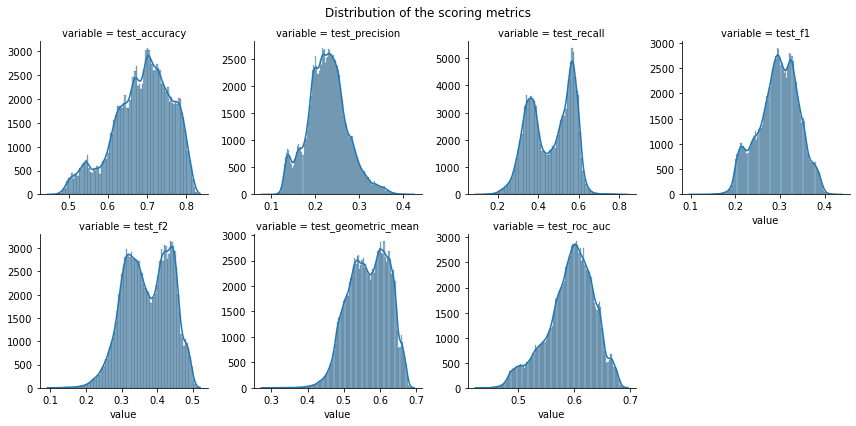

In [5]:
tmp = pd.melt(scores_data, value_vars=test_metrics)
g = sns.FacetGrid(data=tmp, col='variable', col_wrap=4, sharex=False, sharey=False)
del tmp
g.map(sns.histplot, 'value', kde=True)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of the scoring metrics')
plt.show()

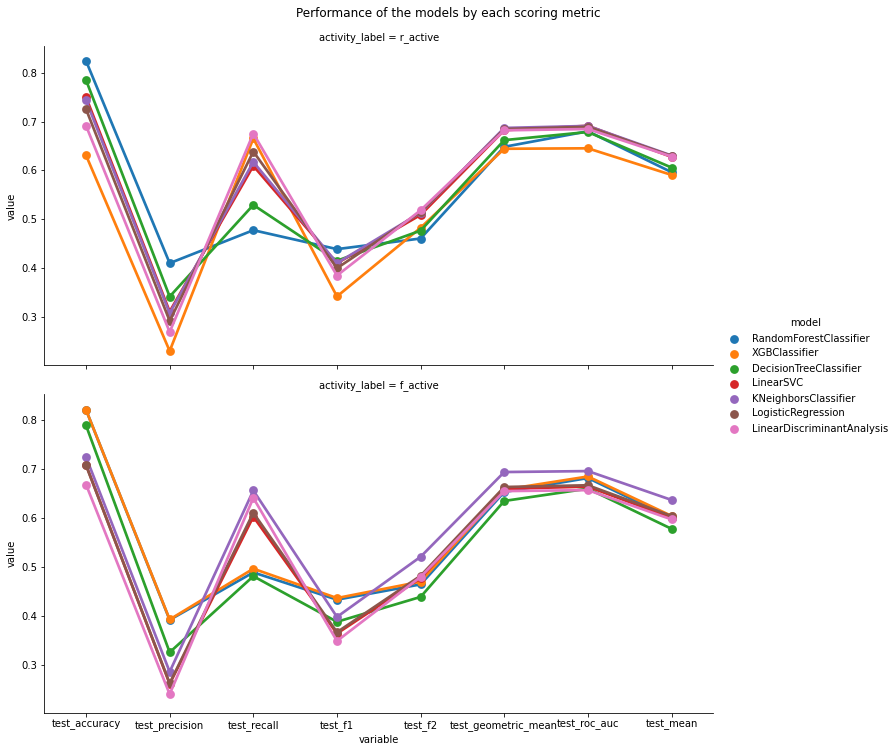

In [6]:
top = pd.melt(scores_data.groupby(['activity_label', 'model']).head(1), id_vars=['activity_label','model',*trainset], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', hue='model', row='activity_label', aspect=2, order=[*test_metrics,'test_mean'])
plt.suptitle('Performance of the models by each scoring metric', y=1.02)
plt.savefig('test_performance.png', dpi=128)

<a id='finding'></a>
### Finding the best subset

In [10]:
# Dictionary: key == model_name, value == list of best descriptors
best_subset = {}

activity_label = 'activity'
for i, row in scores_data.query('activity_label == @activity_label').groupby('model').head(1).iterrows():
    best_subset[row['model']] = [descriptor for descriptor in trainset if row[descriptor]]

<a id='reconstructing'></a>
### Reconstructing the top models

In [11]:
def get_model_by_name(model_name):
    if model_name == 'LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        return LogisticRegression(solver='liblinear', random_state=13)
    elif model_name == 'LinearSVC':
        from sklearn.svm import LinearSVC
        from sklearn.calibration import CalibratedClassifierCV
        # CalibratedClassifierCV is used for applying probability transformation 
        # on top of the SVC outputs, so we can plot the ROC curve
        # https://stackoverflow.com/a/39712590/13131079
        return CalibratedClassifierCV(base_estimator=LinearSVC(dual=False, random_state=13))
    elif model_name == 'RandomForestClassifier':
        from sklearn.ensemble import RandomForestClassifier
        return RandomForestClassifier(n_estimators=40, max_depth=6, random_state=13)
    elif model_name == 'KNeighborsClassifier':
        from sklearn.neighbors import KNeighborsClassifier
        return KNeighborsClassifier(n_neighbors=5)
    elif model_name == 'XGBClassifier':
        from xgboost import XGBClassifier
        return XGBClassifier(objective='reg:logistic', n_estimators=40, 
            max_depth=3, eta=0.2, random_state=13)
    elif model_name == 'DecisionTreeClassifier':
        from sklearn.tree import DecisionTreeClassifier
        return DecisionTreeClassifier(max_depth=6, random_state=13)
    elif model_name == 'LinearDiscriminantAnalysis':
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        return LinearDiscriminantAnalysis(solver='svd')
    else:
        return None

In [12]:
from sklearn.metrics import fbeta_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import geometric_mean_score

# Probabilities for the top models
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# List of scores for the top models
scores_list = []
new_data = data.dropna(subset=trainset)

test_metrics = selected
train_metrics = [i.replace('test', 'train') for i in selected]
scoring_metrics = test_metrics + train_metrics

count = 0
for key, value in best_subset.items():
    model_name = key
    subset = value
    
    y = new_data[activity_label]
    X = new_data[subset]
            
    scaler = StandardScaler()
    pipe = make_pipeline(SMOTE(random_state=42), scaler, get_model_by_name(model_name))
        
    metrics_dict = {key: [] for key in scoring_metrics}
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    for train_index, test_index in skf.split(X, y): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
        model_fitted = pipe.fit(X_train, y_train)
        
        # Test predictions
        y_pred = model_fitted.predict(X_test)
        metrics_dict['test_f2'].append(fbeta_score(y_test, y_pred, beta=2)) # test_f2
        metrics_dict['test_geometric_mean'].append(geometric_mean_score(y_test, y_pred)) # test_geometric_mean
        metrics_dict['test_roc_auc'].append(roc_auc_score(y_test, y_pred)) # test_roc_auc
        
        # Training predictions
        y_pred = model_fitted.predict(X_train)
        metrics_dict['train_f2'].append(fbeta_score(y_train, y_pred, beta=2)) # train_f2
        metrics_dict['train_geometric_mean'].append(geometric_mean_score(y_train, y_pred)) # train_geometric_mean
        metrics_dict['train_roc_auc'].append(roc_auc_score(y_train, y_pred)) # train_roc_auc
    
    # Mean of the KFold scores
    scores = [np.mean(value) for value in metrics_dict.values()]
    scores_list.append([model_name, *scores])
    
    y_proba_train = model_fitted.predict_proba(X_train)
    train_data[model_name] = y_proba_train[:,1]

    y_proba_test = model_fitted.predict_proba(X_test)
    test_data[model_name] = y_proba_test[:,1]
    
    # Keep original indices
    test_data.index = X_test.index
    count+=1

columns = ['model', *scoring_metrics]
top_scores = pd.DataFrame(scores_list, columns=columns)
top_scores['test_mean'] = top_scores[test_metrics].mean(axis=1)
top_scores['train_mean'] = top_scores[train_metrics].mean(axis=1)

<a id='roc_curves'></a>
### ROC curves

No handles with labels found to put in legend.
No handles with labels found to put in legend.


,model,test_f2,test_geometric_mean,test_roc_auc,train_f2,train_geometric_mean,train_roc_auc,test_mean,train_mean


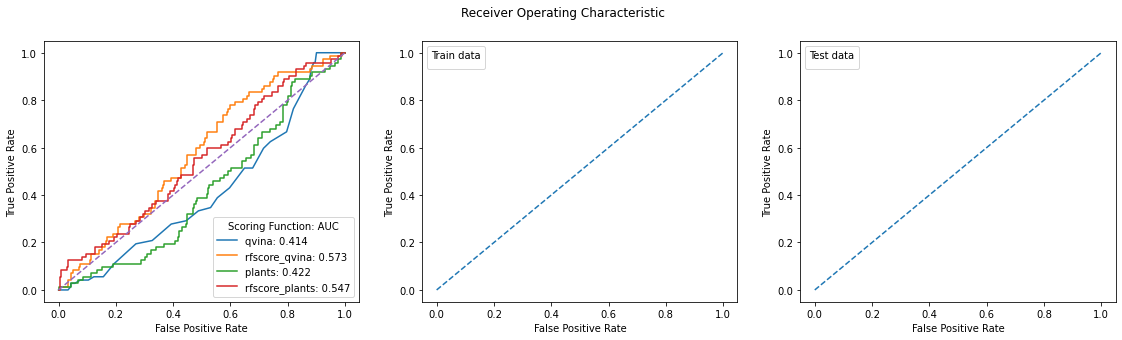

In [14]:
fig, ax = plt.subplots(ncols=3, figsize=(19.2, 4.8))

# Plot ROC curves for the docking scoring functions
for SF in docking_list:
    fpr, tpr, _ = roc_curve(data[activity_label].values, data[SF].values)
    ax[0].plot(fpr, tpr, label=f'{SF}: {auc(fpr, tpr):>.3f}')

# Plot ROC curves for the ML models
for model_name in best_subset.keys():
    fpr_train, tpr_train,_ = roc_curve(y_train, train_data[model_name])
    ax[1].plot(fpr_train, tpr_train, label=f'{model_name}')
    
    fpr_test, tpr_test,_ = roc_curve(y_test, test_data[model_name])
    ax[2].plot(fpr_test, tpr_test, label=f'{model_name}')

for i in range(3):
    # Plot a line
    ax[i].plot([0,1], [0,1], linestyle='--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')

# Some legends
ax[0].legend(title='Scoring Function: AUC', loc='lower right')
ax[1].legend(title='Train data')
ax[2].legend(title='Test data')

plt.suptitle('Receiver Operating Characteristic')
plt.savefig('test_roc_curve.png', dpi=216)

# Incluir ordem

top_scores

<a id='supplementary'></a>
## Supplementary data
<a id='comparing'></a>
### Comparing models and labels

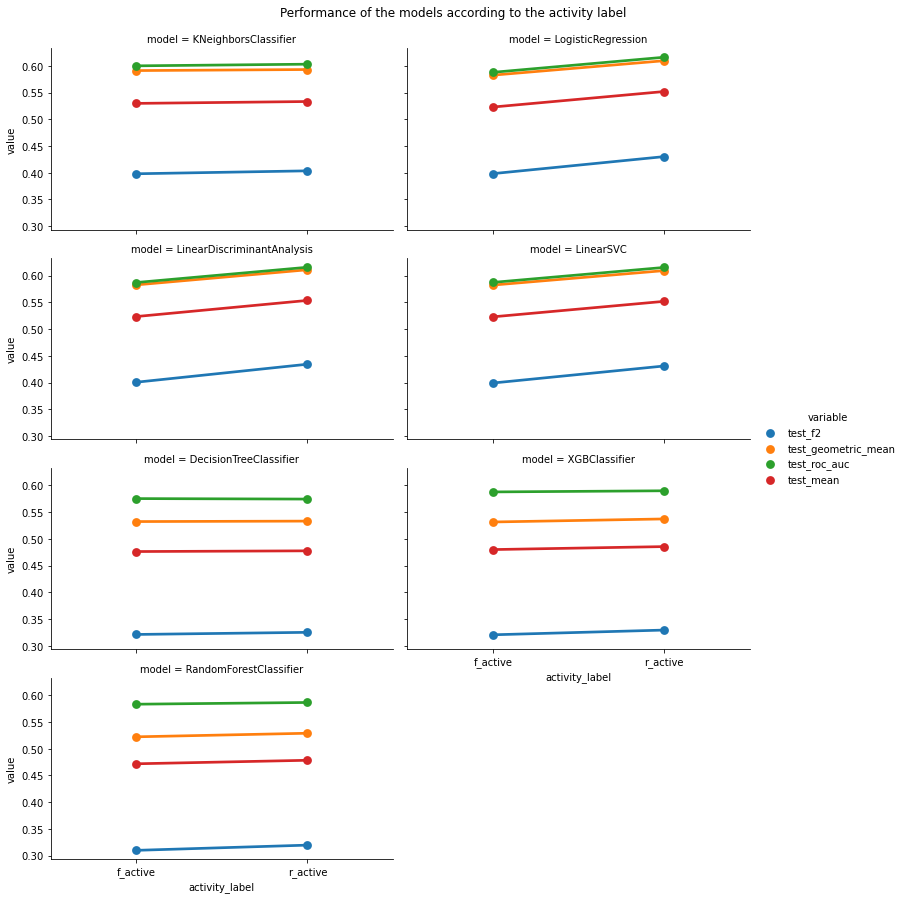

In [15]:
melt = pd.melt(scores_data, id_vars=['activity_label','model',*trainset], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=melt, x='activity_label', y='value', hue='variable', col='model', col_wrap=2, height=3, aspect=1.75)
plt.suptitle('Performance of the models according to the activity label', y=1.02)
plt.show()

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(scores_data.groupby(['model','activity_label']).describe())

job_id                       \
                                            count    mean          std   
model                      activity_label                                
DecisionTreeClassifier     f_active        8840.0  9283.5  1786.421635   
                           r_active        8840.0  3095.5  1786.421635   
KNeighborsClassifier       f_active        8840.0  9280.5  1786.421635   
                           r_active        8840.0  3092.5  1786.421635   
LinearDiscriminantAnalysis f_active        8840.0  9284.5  1786.421635   
                           r_active        8840.0  3096.5  1786.421635   
LinearSVC                  f_active        8840.0  9281.5  1786.421635   
                           r_active        8840.0  3093.5  1786.421635   
LogisticRegression         f_active        8840.0  9278.5  1786.421635   
                           r_active        8840.0  3090.5  1786.421635   
RandomForestClassifier     f_active        8840.0  9279.5  1786.421635   
                           r_active        8840.0  3091.5  1786.421635   
XGBClassifier              f_active        8840.0  9282.5  1786.421635   
                           r_active        8840.0  3094.5  1786.421635   

                                                                              \
                                              min      25%     50%       75%   
model                      activity_label                                      
DecisionTreeClassifier     f_active        6193.0  7738.25  9283.5  10828.75   
                           r_active           5.0  1550.25  3095.5   4640.75   
KNeighborsClassifier       f_active        6190.0  7735.25  9280.5  10825.75   
                           r_active           2.0  1547.25  3092.5   4637.75   
LinearDiscriminantAnalysis f_active        6194.0  7739.25  9284.5  10829.75   
                           r_active           6.0  1551.25  3096.5   4641.75   
LinearSVC                  f_active        6191.0  7736.25  9281.5  10826.75   
                           r_active           3.0  1548.25  3093.5   4638.75   
LogisticRegression         f_active        6188.0  7733.25  9278.5  10823.75   
                           r_active           0.0  1545.25  3090.5   4635.75   
RandomForestClassifier     f_active        6189.0  7734.25  9279.5  10824.75   
                           r_active           1.0  1546.25  3091.5   4636.75   
XGBClassifier              f_active        6192.0  7737.25  9282.5  10827.75   
                           r_active           4.0  1549.25  3094.5   4639.75   

                                                   test_accuracy            \
                                               max         count      mean   
model                      activity_label                                    
DecisionTreeClassifier     f_active        12374.0        8840.0  0.725413   
                           r_active         6186.0        8840.0  0.720027   
KNeighborsClassifier       f_active        12371.0        8840.0  0.661659   
                           r_active         6183.0        8840.0  0.671028   
LinearDiscriminantAnalysis f_active        12375.0        8840.0  0.614199   
                           r_active         6187.0        8840.0  0.647911   
LinearSVC                  f_active        12372.0        8840.0  0.618598   
                           r_active         6184.0        8840.0  0.654229   
LogisticRegression         f_active        12369.0        8840.0  0.622492   
                           r_active         6181.0        8840.0  0.658780   
RandomForestClassifier     f_active        12370.0        8840.0  0.763680   
                           r_active         6182.0        8840.0  0.760370   
XGBClassifier              f_active        12373.0        8840.0  0.760510   
                           r_active         6185.0        8840.0  0.755576   

                                                                         \
                     

<a id='docking'></a>
### Docking scores and performance increment

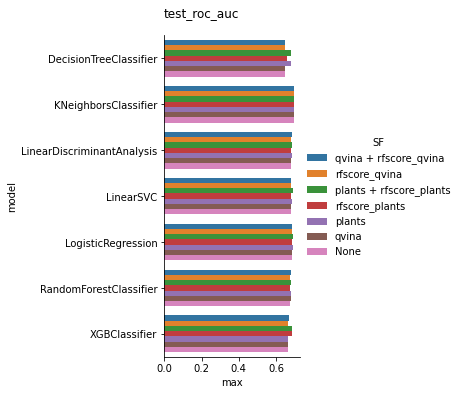

In [17]:
'''
combinations = [('qvina', 'rfscore_qvina'),
                ('plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants'),
                ('qvina', 'rfscore_qvina', 'rfscore_plants'),
                ('qvina', 'plants', 'rfscore_plants'),
                ('rfscore_qvina', 'plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants', 'rfscore_plants')]
'''

df = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
df['SF'] = 'None'

tmp = scores_data.query('rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina + rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants + rfscore_plants'
df = df.append(tmp)

del tmp
df.reset_index(inplace=True)
df.sort_values(['model','mean','max'], inplace=True)

#compare = pd.melt(df, id_vars=['model','SF'], value_vars=['mean','max'])
sns.catplot(kind='bar', data=df, y='model', x='max', hue='SF')
plt.suptitle('test_roc_auc', y=1.05)
plt.show()

The barplot above indicates the performance scores don't increase when docking scores are taken into account. In fact, all models' average scores, and most models' top scores, are higher when only the molecular descriptors are evaluated, although "qvina" and "qvina" + "rfscore_qvina" consistently have higher scores for all models.

<a id='top_descriptors'></a>
### Top descriptors

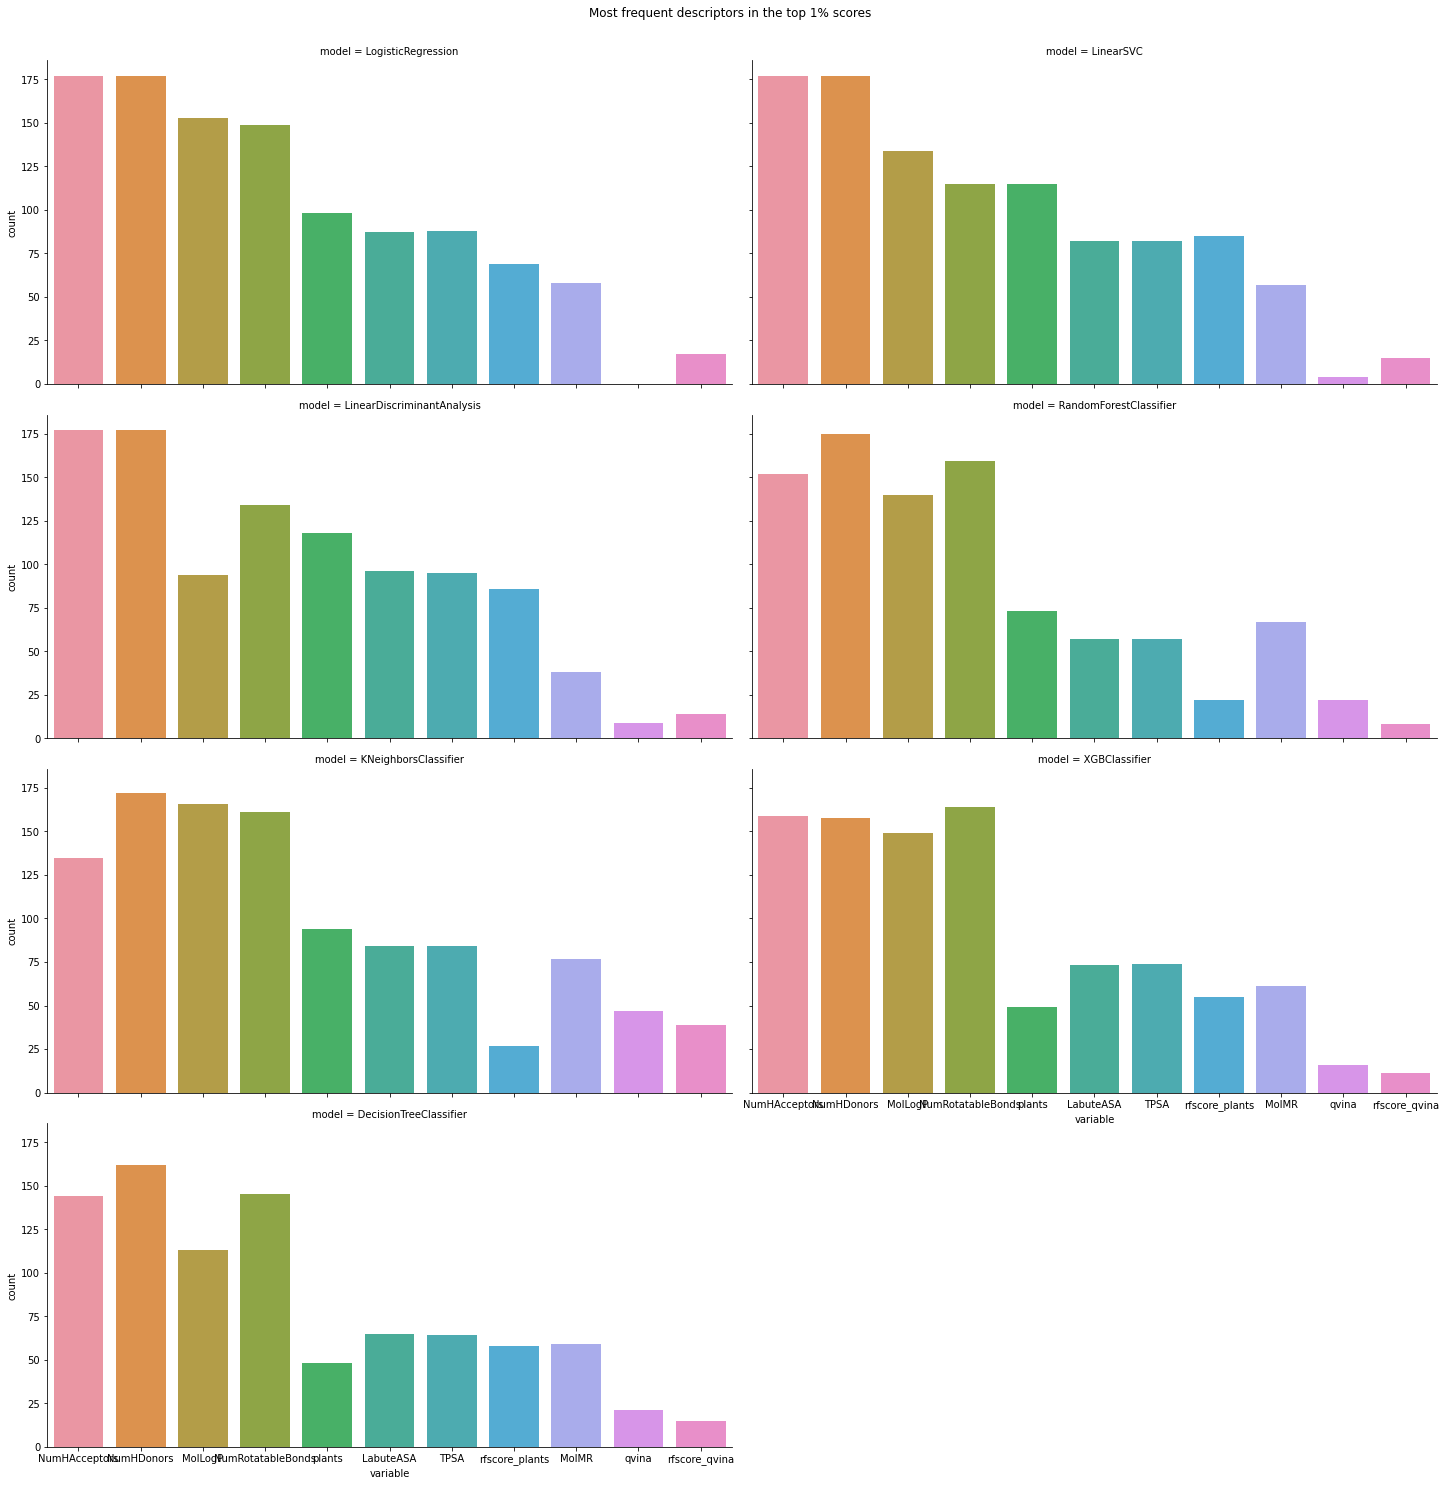

In [18]:
# How frequently does each descriptor appear in the top 1% scores for each model?
N = np.ceil(0.01 * len(scores_data.query('model == "LogisticRegression"')))
tmp = pd.melt(scores_data, id_vars=[*test_metrics,'activity_label','model','test_mean'], value_vars=trainset, value_name='count')
count = pd.DataFrame(tmp.groupby(['model','variable']).head(N).groupby(['model','variable'])['count'].value_counts())
del tmp

count.index.names = ['model','variable','value']
count.reset_index(level=[0,1,2], inplace=True)
count = count.query('value == 1').sort_values('count', ascending=False)
count.drop('value', axis=1, inplace=True)

g = sns.catplot(kind='bar', data=count, x='variable', y='count', col='model', col_wrap=2, aspect=2)

# Set title
plt.suptitle('Most frequent descriptors in the top 1% scores', y=1.02)
plt.show()

In [19]:
print('The frequency count shows the most recurring descriptors in each model\'s top 1% results are: ')
for key, value in best_subset.items():
    print(key, value)

The frequency count shows the most recurring descriptors in each model's top 1% results are: 


<a id='confusion_matrix'></a>
### Confusion matrix for the best model

In [20]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, log_loss

model_name = top_scores.sort_values('test_mean', ascending=False).iloc[0]['model']
subset = best_subset[model_name]

y = new_data[activity_label]
X = new_data[subset]

scaler = StandardScaler()
pipe = make_pipeline(SMOTE(random_state=42), scaler, XGBClassifier(objective='reg:logistic', random_state=13))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for train_index, test_index in skf.split(X, y): 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
    break
    
pipe = pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

#     Predicted   inactive |  active
# Actual 
# inactive      |    TN    |    FP    | 
# active        |    FN    |    TP    | 

conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
matrix = pd.DataFrame(conf_matrix)

print(model_name)
print(f'RMSE: {np.linalg.norm(y_proba - y_test) / np.sqrt(len(y_test)):.4f}')
print(f'log_loss: {log_loss(y_test, y_proba):.4f}')
matrix

IndexError: single positional indexer is out-of-bounds

In [ ]:
df = scores_data.copy()
df[test_metrics] = StandardScaler().fit_transform(scores_data[test_metrics])
tmp = pd.melt(df, value_vars=test_metrics)
g = sns.FacetGrid(data=tmp, col='variable', col_wrap=4, sharex=False, sharey=False)
del tmp
g.map(sns.histplot, 'value', kde=True)

In [ ]:
top = pd.melt(df.groupby(['activity_label', 'model']).head(1), id_vars=['activity_label','model',*trainset], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', hue='model', row='activity_label', aspect=2, order=[*test_metrics,'test_mean'])
plt.savefig('test_performance.png', dpi=216)

In [ ]:
df = scores_data.copy()
df[test_metrics] = MinMaxScaler().fit_transform(scores_data[test_metrics])
tmp = pd.melt(df, value_vars=test_metrics)
g = sns.FacetGrid(data=tmp, col='variable', col_wrap=4, sharex=False, sharey=False)
del tmp
g.map(sns.histplot, 'value', kde=True)

In [ ]:
top = pd.melt(df.groupby(['activity_label', 'model']).head(1), id_vars=['activity_label','model',*trainset], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', hue='model', row='activity_label', aspect=2, order=[*test_metrics,'test_mean'])
plt.savefig('test_performance.png', dpi=216)

<a id='regression'></a>
### Regression plots

In [ ]:
from scipy.stats import spearmanr

test_data['CID'] = data.loc[test_data.index]['CID']
tmp = pd.melt(test_data, id_vars=['CID'], value_vars=test_data.columns[:-1])
tmp = tmp.append(pd.melt(data.loc[test_data.index], id_vars=['CID'], value_vars=['qvina','rfscore_qvina','plants','rfscore_plants']))
df_tidy = pd.merge(data.loc[test_data.index][['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM']], tmp, on=['CID'])

g = sns.FacetGrid(data=df_tidy, col='variable', col_wrap=4, sharey=False)
g.map(sns.regplot, 'f_inhibition_at_50_uM', 'value')

# Set title
plt.suptitle('Regression plots for the test set', y=1.02)
plt.show()

<a id='correlations'></a>
### Correlations

In [ ]:
# Pearson correlations with inhibitions
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM'], 
                    columns='variable',values='value').reset_index().corr(method='pearson')[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']]

In [ ]:
# Spearman correlations with inhibitions
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM'], 
                    columns='variable',values='value').reset_index().corr(method='spearman')[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']]

<a id='number_of_features'></a>
### Performance according to the number of features

In [23]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestClassifier

y = data['activity']
X = data[descriptors_list]

# Estimator
model_name = 'XGBClassifier'
estimator = get_model_by_name(model_name)
# Step Forward Feature Selector
StepForward = sfs(estimator, k_features=6, forward=True, floating=False, verbose=2, scoring='accuracy', cv=5)                                   

StepForward.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.6s finished

[2020-12-05 20:03:28] Features: 1/6 -- score: 0.7456140350877193[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s finished

[2020-12-05 20:03:28] Features: 2/6 -- score: 0.7099624060150376[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished

[2020-12-05 20:03:29] Features: 3/6 -- score: 0.6713659147869675[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

SequentialFeatureSelector(estimator=XGBClassifier(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  eta=0.2, gamma=None,
                                                  gpu_id=None,
                                                  importance_type='gain',
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=3,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=

In [26]:
StepForward.subsets_

{1: {'feature_idx': (3,),
  'cv_scores': array([0.75438596, 0.73684211, 0.73684211, 0.75      , 0.75      ]),
  'avg_score': 0.7456140350877193,
  'feature_names': ('NumHDonors',)},
 2: {'feature_idx': (2, 3),
  'cv_scores': array([0.73684211, 0.73684211, 0.73684211, 0.60714286, 0.73214286]),
  'avg_score': 0.7099624060150376,
  'feature_names': ('NumHAcceptors', 'NumHDonors')},
 3: {'feature_idx': (1, 2, 3),
  'cv_scores': array([0.66666667, 0.73684211, 0.61403509, 0.60714286, 0.73214286]),
  'avg_score': 0.6713659147869675,
  'feature_names': ('NumRotatableBonds', 'NumHAcceptors', 'NumHDonors')},
 4: {'feature_idx': (1, 2, 3, 4),
  'cv_scores': array([0.77192982, 0.63157895, 0.42105263, 0.78571429, 0.71428571]),
  'avg_score': 0.6649122807017543,
  'feature_names': ('NumRotatableBonds',
   'NumHAcceptors',
   'NumHDonors',
   'TPSA')},
 5: {'feature_idx': (1, 2, 3, 4, 6),
  'cv_scores': array([0.70175439, 0.63157895, 0.40350877, 0.75      , 0.69642857]),
  'avg_score': 0.636654135338

In [27]:
# Selected feature columns
cols = list(StepForward.k_feature_idx_)
cols

[1, 2, 3, 4, 5, 6]

In [28]:
features = X.columns[cols]
features

Index(['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'TPSA', 'LabuteASA',
       'MolLogP'],
      dtype='object')

In [29]:
StepForward.k_feature_names_

('NumRotatableBonds',
 'NumHAcceptors',
 'NumHDonors',
 'TPSA',
 'LabuteASA',
 'MolLogP')

In [30]:
StepForward.k_score_

0.6330200501253133

best combination (ACC: 0.633): (1, 2, 3, 4, 5, 6)

all subsets:
 {1: {'feature_idx': (3,), 'cv_scores': array([0.75438596, 0.73684211, 0.73684211, 0.75      , 0.75      ]), 'avg_score': 0.7456140350877193, 'feature_names': ('NumHDonors',)}, 2: {'feature_idx': (2, 3), 'cv_scores': array([0.73684211, 0.73684211, 0.73684211, 0.60714286, 0.73214286]), 'avg_score': 0.7099624060150376, 'feature_names': ('NumHAcceptors', 'NumHDonors')}, 3: {'feature_idx': (1, 2, 3), 'cv_scores': array([0.66666667, 0.73684211, 0.61403509, 0.60714286, 0.73214286]), 'avg_score': 0.6713659147869675, 'feature_names': ('NumRotatableBonds', 'NumHAcceptors', 'NumHDonors')}, 4: {'feature_idx': (1, 2, 3, 4), 'cv_scores': array([0.77192982, 0.63157895, 0.42105263, 0.78571429, 0.71428571]), 'avg_score': 0.6649122807017543, 'feature_names': ('NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'TPSA')}, 5: {'feature_idx': (1, 2, 3, 4, 6), 'cv_scores': array([0.70175439, 0.63157895, 0.40350877, 0.75      , 0.69642857]), 'av

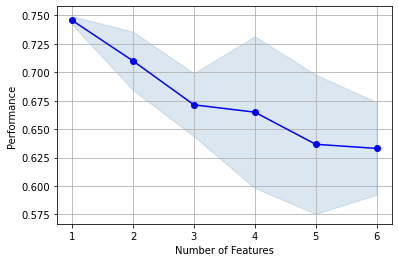

In [31]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

print('best combination (ACC: %.3f): %s\n' % (StepForward.k_score_, StepForward.k_feature_idx_))
print('all subsets:\n', StepForward.subsets_)
plot_sfs(StepForward.get_metric_dict(), kind='std_err');
plt.grid()